In [ ]:
!pip install wfdb
!pip install numpy pandas matplotlib scipy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 2.2 MB/s eta 0:00:00


In [ ]:
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import wfdb

# Ruta a la carpeta que contiene los archivos de ECG
ruta_archivo = '/content/drive/MyDrive/Clases/7mo Semestre/archivos/100/100'

# Cargar el registro de ECG y las anotaciones
record = wfdb.rdsamp(ruta_archivo)  # Cargar el archivo de la señal
annotations = wfdb.rdann(ruta_archivo, 'atr')  # Cargar las anotaciones de latidos

# Descomponer la tupla de resultados
ecg_signal, fields = record  # ecg_signal contiene la señal, fields contiene metadatos
fs = fields['fs']  # Frecuencia de muestreo

# Mostrar información de la señal y las anotaciones
print("Frecuencia de muestreo:", fs)
print("Forma de la señal ECG:", ecg_signal.shape)  # Forma de la señal ECG
print("Número de anotaciones:", len(annotations.sample))  # Número de anotaciones


Frecuencia de muestreo: 360
Forma de la señal ECG: (650000, 2)
Número de anotaciones: 2274


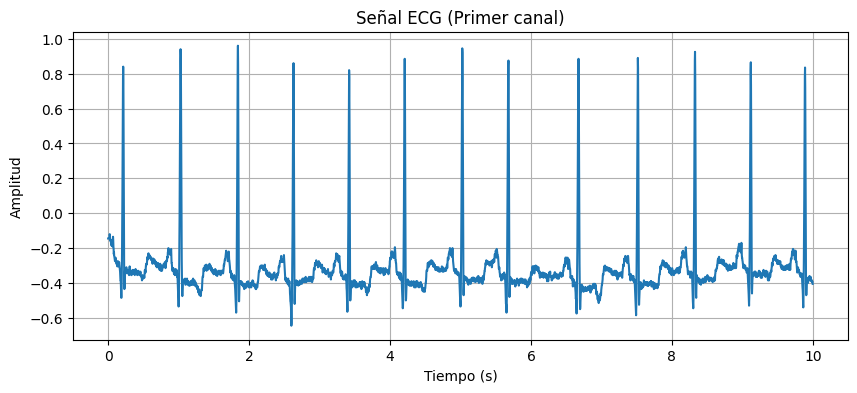

In [ ]:
import matplotlib.pyplot as plt

# Extraer el primer canal de la señal ECG
signal_channel_1 = ecg_signal[:, 0]

# Crear un eje de tiempo en segundos
tiempo = [i / fs for i in range(len(signal_channel_1))]

# Graficar los primeros 10 segundos de la señal
plt.figure(figsize=(10, 4))
plt.plot(tiempo[:10*fs], signal_channel_1[:10*fs])
plt.title("Señal ECG (Primer canal)")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.grid()
plt.show()


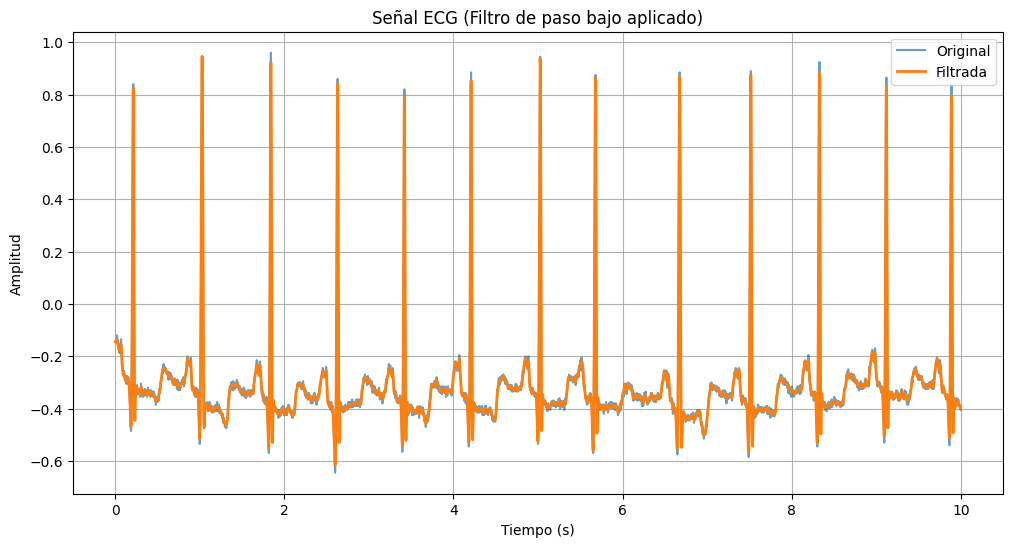

In [ ]:
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt

# Función para diseñar y aplicar un filtro de paso bajo
def filtro_paso_bajo(signal, fs, cutoff=50, order=4):
    """
    Filtra una señal utilizando un filtro de paso bajo.

    Parámetros:
    - signal: array, la señal a filtrar
    - fs: int, frecuencia de muestreo de la señal
    - cutoff: float, frecuencia de corte en Hz
    - order: int, orden del filtro

    Devuelve:
    - Señal filtrada
    """
    nyquist = 0.5 * fs  # Frecuencia de Nyquist
    normal_cutoff = cutoff / nyquist  # Frecuencia de corte normalizada
    # Diseñar el filtro Butterworth
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    # Aplicar el filtro a la señal
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# Extraer el primer canal de la señal ECG
signal_channel_1 = ecg_signal[:, 0]

# Filtrar la señal con una frecuencia de corte de 50 Hz
filtered_signal = filtro_paso_bajo(signal_channel_1, fs, cutoff=50)

# Crear un eje de tiempo en segundos
tiempo = [i / fs for i in range(len(signal_channel_1))]

# Graficar la señal original y la filtrada
plt.figure(figsize=(12, 6))
plt.plot(tiempo[:10*fs], signal_channel_1[:10*fs], label='Original', alpha=0.7)
plt.plot(tiempo[:10*fs], filtered_signal[:10*fs], label='Filtrada', linewidth=2)
plt.title("Señal ECG (Filtro de paso bajo aplicado)")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.legend()
plt.grid()
plt.show()


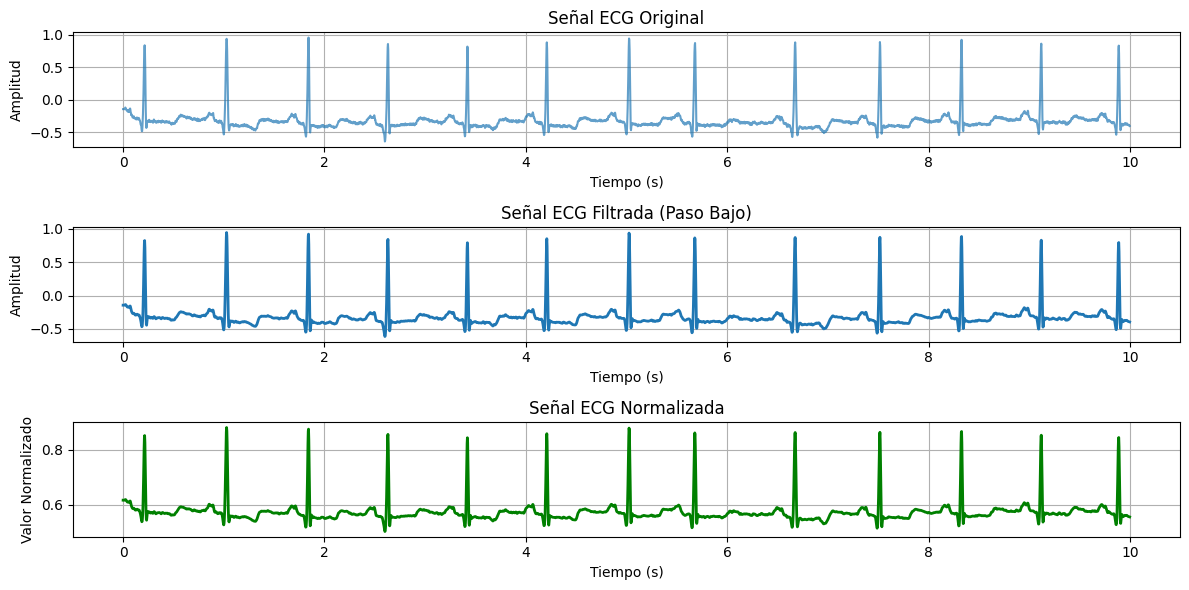

In [ ]:
import numpy as np

# Función para normalizar la señal entre 0 y 1
def normalizar_señal(signal):
    """
    Normaliza una señal para que sus valores estén en el rango [0, 1].

    Parámetros:
    - signal: array, la señal a normalizar.

    Devuelve:
    - Señal normalizada.
    """
    min_val = np.min(signal)  # Valor mínimo de la señal
    max_val = np.max(signal)  # Valor máximo de la señal
    return (signal - min_val) / (max_val - min_val)

# Normalizar la señal filtrada (primer canal)
normalized_signal = normalizar_señal(filtered_signal)

# Graficar la señal original, filtrada y normalizada
plt.figure(figsize=(12, 6))

# Señal original
plt.subplot(3, 1, 1)
plt.plot(tiempo[:10*fs], signal_channel_1[:10*fs], label='Original', alpha=0.7)
plt.title("Señal ECG Original")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.grid()

# Señal filtrada
plt.subplot(3, 1, 2)
plt.plot(tiempo[:10*fs], filtered_signal[:10*fs], label='Filtrada', linewidth=2)
plt.title("Señal ECG Filtrada (Paso Bajo)")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.grid()

# Señal normalizada
plt.subplot(3, 1, 3)
plt.plot(tiempo[:10*fs], normalized_signal[:10*fs], label='Normalizada', color='g', linewidth=2)
plt.title("Señal ECG Normalizada")
plt.xlabel("Tiempo (s)")
plt.ylabel("Valor Normalizado")
plt.grid()

plt.tight_layout()
plt.show()


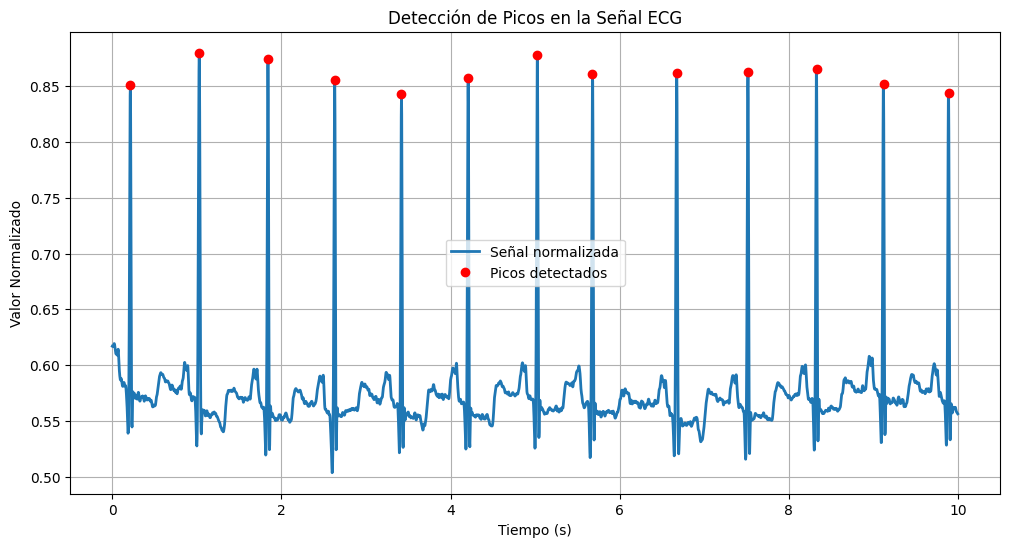

Número total de picos detectados: 2273
Frecuencia cardíaca promedio: 75.53 latidos por minuto


In [ ]:
from scipy.signal import find_peaks

# Detección de picos en la señal normalizada
def detectar_picos(signal, altura_minima=0.5, distancia_minima=None, fs=360):
    """
    Detecta picos en una señal normalizada.

    Parámetros:
    - signal: array, la señal en la que se detectarán los picos.
    - altura_minima: float, valor mínimo que debe tener un pico para ser considerado.
    - distancia_minima: int o None, distancia mínima entre picos en muestras (opcional).
    - fs: int, frecuencia de muestreo (para calcular la distancia mínima en segundos).

    Devuelve:
    - Indices de los picos detectados.
    """
    if distancia_minima:
        distancia_minima = int(distancia_minima * fs)  # Convertir a muestras
    indices_picos, _ = find_peaks(signal, height=altura_minima, distance=distancia_minima)
    return indices_picos

# Detectar picos (usando una altura mínima de 0.5 y distancia mínima de 0.6 s)
altura_minima = 0.5
distancia_minima = 0.6  # En segundos
indices_picos = detectar_picos(normalized_signal, altura_minima, distancia_minima, fs)

# Graficar la señal normalizada con los picos detectados
plt.figure(figsize=(12, 6))
plt.plot(tiempo[:10*fs], normalized_signal[:10*fs], label='Señal normalizada', linewidth=2)
plt.plot([tiempo[i] for i in indices_picos if i < 10*fs],
         [normalized_signal[i] for i in indices_picos if i < 10*fs],
         'ro', label='Picos detectados')
plt.title("Detección de Picos en la Señal ECG")
plt.xlabel("Tiempo (s)")
plt.ylabel("Valor Normalizado")
plt.legend()
plt.grid()
plt.show()

# Mostrar información sobre los picos detectados
print(f"Número total de picos detectados: {len(indices_picos)}")
print(f"Frecuencia cardíaca promedio: {len(indices_picos) * 60 / (len(normalized_signal) / fs):.2f} latidos por minuto")
